# Project 7 - Identifying Enron POIs

This notebook will be a rough guide to my thoughts in how I explored the data, enabling visualisation of the data.

*** Questions still to answer ***
* Using lasso regression on binary labels?
* Zeros for ratios ok, but not for other data - how top ensure this?

In [1]:
# Initialise initial libraries and requirements
# Copied from poi_id.py
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
from sklearn.cross_validation import train_test_split 
from sklearn.model_selection import KFold


/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
# Add a full list of the features available to us
fin_features = ["salary",
                "deferral_payments",
                "total_payments",
                "loan_advances",
                "bonus",
                "restricted_stock_deferred",
                "deferred_income",
                "total_stock_value",
                "expenses",
                "exercised_stock_options",
                "other",
                "long_term_incentive",
                "restricted_stock",
                "director_fees"]
email_features = ["to_messages",
                  #"email_address",
                  "from_poi_to_this_person",
                  "from_messages",
                  "from_this_person_to_poi",
                  "shared_receipt_with_poi"]
features_list = ["poi"] # You will need to use more features

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)
    
# Load features and split them out
data = featureFormat(data_dict, features_list)
labels, features = targetFeatureSplit(data)

# Separate into training and testing
if False:
    features_train, features_test, labels_train, labels_test = train_test_split(
        features, labels, test_size=.25)
if False:
    # K-fold validation
    pass

In [3]:
# Print some stats on our data
# Test code: for key in dict; dict.keys()
persons = data_dict.keys()
print "Number of persons: ", len(persons)
# Display details about the financial features
fin_feature_list = ["poi"]
fin_feature_list.extend(fin_features)
fin_data = featureFormat(data_dict, fin_feature_list, 
                         remove_NaN=False, remove_all_zeroes=False)
fin_label, fin_features = targetFeatureSplit(fin_data)
#print fin_data
print "Number of POIs: ", sum(fin_label)

Number of persons:  146
Number of POIs:  18.0


Initially we encountered a problem when attempting to use the "email_address" field as this was not a number and hence created an error in featureFormat function. However this does not appear to be a huge loss as we would not expect a person's name to be a factor in whether they are a poi or not (and in real life if fed into a machine learning algorithm this may actually be "overfitting" data as it may be "looking up" the answer from other sources). Also email adresses do not specify rank which may have information value.

### Classifiers to Use
Now what we are trying to determine is whether a person is a Person of Interest (POI). This is binary label (indeed it is denoted 0 or 1 in the "poi" field) - so we should mainly be applying classifiers that work on discrete as opposed to continuous variables (such as regressions).

### A first approach - using emails
One approach to identifying POIs could be to use the number of emails that they send, receive or cc'd on with other POIs. Anecdotally, one would seem to be in communication with the people they work most closely with and we would expect POIs working closely to maintain their fraudulent scheme.

In [4]:
# Using email features
# First ensure that we have the labels which we want.
features_list = ["poi", 
                 "from_poi_to_this_person",
                 "from_this_person_to_poi",
                 "shared_receipt_with_poi"]
#features_list.extend(email_features)
#data = featureFormat(data_dict, features_list, remove_all_zeroes=False)
data = featureFormat(data_dict, features_list)
labels, features = targetFeatureSplit(data) 

print "Sample size: ", len(labels)
print "Number of POIs: ", sum(labels)

Sample size:  86
Number of POIs:  14.0


We can see here that after removing persons with all zeros from our data set, we are left with only 14 out of our initial 18 POIs. In total, we have removed 60 persons from our 146 person sample and 4 of them being POIs. Initially, POIs were 12.3% of our sample, now they are 16.3% of our sample. It is usueful to keep this in mind when considering whether we are happy with the algorithm that we have built. In this case, we would need to investigate why there are people with no emails - it is likely that the records are incomplete - therefore we would not want the algorithm to use the lack of an emails as a flag as to whether the person is or isn't a POI.

In [5]:
# Split our data into training and testing sets
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, test_size=.25, random_state=3)

# Do a quick test fit to guage the result of any outlier removal or transformation.
# Our initial fit is to use K-Means clustering based on our theory
from sklearn.cluster import KMeans
clf = KMeans(n_clusters=2, max_iter=100)
clf.fit(features_train)
pred = clf.predict(features_test)

# Create a function to test our classifier
# More detailed stats
def clf_test(labels, pred):
    if len(labels) != len(pred):
        print "Lists not of same length"
        return
    tp = 0 # True positives
    tn = 0 # True negatives
    fp = 0 # False positives
    fn = 0 # False negatives
    for i in range(len(labels)):
        if labels[i] == pred[i]:
            if labels[i] == 1:
                tp += 1
            else:
                tn += 1
        else:
            if labels[i] == 0:
                fp += 1
            else:
                fn += 1
    print "Accuracy: ", ((tp+tn) / float(len(labels)))
    print "Recall: ", float(tp) / (tp + fn)
    print "Precision: ", float(tp) / (tp + fp)
clf_test(labels_test, pred)

Accuracy:  0.681818181818
Recall:  0.333333333333
Precision:  0.166666666667


We can see that our initial attempt does quite poorly. We will see what can be causing this performance, however as we have seen the sample size is quite small and there are a low number of POIs. There could be some outliers that are affecting the performance of our algorithm.

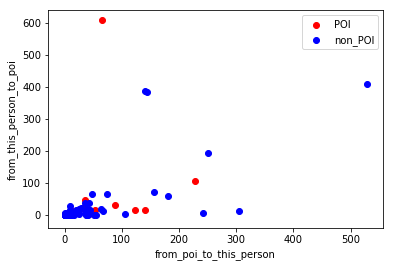

In [6]:
### Task 2: Remove outliers
# We plot the data to see if there are any outliers for us to plot.
poi_x = []
poi_y = []
non_poi_x = []
non_poi_y = []
#Create arrays for outlier cleaning
from_poi_train = []
to_poi_train = []
for i in range(len(labels_train)):
    x, y, _ = features_train[i]
    from_poi_train.append(x)
    to_poi_train.append(y)
    if labels_train[i] == 1:
        poi_x.append(x)
        poi_y.append(y)
    elif labels_train[i] == 0:
        non_poi_x.append(x)
        non_poi_y.append(y)
plt.scatter(poi_x, poi_y, color = "r", label = "POI")
plt.scatter(non_poi_x, non_poi_y, color = "b", label = "non_POI")
plt.legend()
plt.xlabel(email_features[1])
plt.ylabel(email_features[3])
plt.savefig("example_poi.png")
plt.show()

From the plot we can see that there seem to be significant outliers in our data set. Most of the persons in our sample have less than 100 emails sent or received from a POI - however there a few extreme outliers who are both POIs and non-POIs. We investigate these people now in our original dataset.

In [7]:
#print data_dict.keys()
fields = ["from_poi_to_this_person", "from_this_person_to_poi"]
crit_val = 300
print "The following have sent or received over ", crit_val, " emails from POIs"
for person in data_dict.keys():
    person_data = data_dict[person]
    to_print = False
    for f in fields:
        if person_data[f] > crit_val and person_data[f] != "NaN":
            to_print = True
    if to_print:
        print "***", person, " ***"
        for email_f in email_features:
            print email_f, ": ", person_data[email_f]
        print "poi: ", person_data["poi"]

The following have sent or received over  300  emails from POIs
*** BECK SALLY W  ***
to_messages :  7315
from_poi_to_this_person :  144
from_messages :  4343
from_this_person_to_poi :  386
shared_receipt_with_poi :  2639
poi:  False
*** LAVORATO JOHN J  ***
to_messages :  7259
from_poi_to_this_person :  528
from_messages :  2585
from_this_person_to_poi :  411
shared_receipt_with_poi :  3962
poi:  False
*** DELAINEY DAVID W  ***
to_messages :  3093
from_poi_to_this_person :  66
from_messages :  3069
from_this_person_to_poi :  609
shared_receipt_with_poi :  2097
poi:  True
*** KEAN STEVEN J  ***
to_messages :  12754
from_poi_to_this_person :  140
from_messages :  6759
from_this_person_to_poi :  387
shared_receipt_with_poi :  3639
poi:  False
*** DIETRICH JANET R  ***
to_messages :  2572
from_poi_to_this_person :  305
from_messages :  63
from_this_person_to_poi :  14
shared_receipt_with_poi :  1902
poi:  False


We can see that most of the people with high counts are not actually POIs, however they have high email counts. 

*** Further research??? ***

We can try removing outliers now.

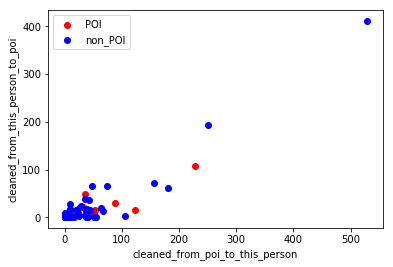


Sample size:  58
Number of POIs 9.0


In [8]:
# Fit a linear regression
# Convert our data into numpy arrays
from_poi_train = np.reshape(np.array(from_poi_train), (len(from_poi_train), 1))
to_poi_train = np.reshape(np.array(to_poi_train), (len(to_poi_train), 1))

from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(from_poi_train, to_poi_train)
reg_pred = reg.predict(from_poi_train)

# Remove outliers
# Create a function to remove our outliers
def remove_outlier(act_val, pred_val, orig_labels, orig_features, remove_percent):
    clean_labels = []
    clean_features = []
    err = abs(pred_val - act_val)
    #print err
    rank = err.transpose().argsort()
    remove_num = -1*int(round(remove_percent*len(err)))
    rank = rank[0][:remove_num]
    for i in rank:
        clean_labels.append(orig_labels[i])
        clean_features.append(orig_features[i])
    return clean_labels, clean_features    
# Clean our current training data set
clean_labels, clean_features = remove_outlier(
    to_poi_train, reg_pred, labels_train, features_train, 0.1)
# Plot our data set
c_poi_x = []
c_poi_y = []
c_non_poi_x = []
c_non_poi_y = []
for i in range(len(clean_labels)):
    x, y, _ = clean_features[i]
    if clean_labels[i] == 1:
        c_poi_x.append(x)
        c_poi_y.append(y)
    elif clean_labels[i] == 0:
        c_non_poi_x.append(x)
        c_non_poi_y.append(y)
plt.scatter(c_poi_x, c_poi_y, color = "r", label = "POI")
plt.scatter(c_non_poi_x, c_non_poi_y, color = "b", label = "non_POI")
plt.legend()
plt.xlabel("cleaned_"+email_features[1])
plt.ylabel("cleaned_"+email_features[3])
plt.savefig("cleaned_example_poi.png")
plt.show()
print ""
print "Sample size: ", len(clean_labels)
print "Number of POIs", sum(clean_labels)

We can see now that our plot is a lot cleaner, with extreme values removed. One concern however is that our data set is now quite small (only 58 persons are left in our sample, with 7 POIs). However we train our classifier now on this cleaned data set and compare.

In [9]:
# Running the classifier on our cleaned data
clean_clf = KMeans(n_clusters=2, max_iter=100)
clean_clf.fit(clean_features)
clean_pred = clean_clf.predict(features_test)
clf_test(labels_test, clean_pred)

Accuracy:  0.727272727273
Recall:  0.333333333333
Precision:  0.2


We note that the accuracy is up - but only marginally. This in fact could have been down to random chance and not conclusive enough given our small sample set. Overall, we see that the Recall is unchanged. Given the small numbver of POIs and the fact that if this were a real fraud identification scenario any candidates would be investigated futher, a higher Recall would be preferable.

One other consideration could be to change transform our variables instead of removing outliers. This would have the advantage of leaving us with a larger training set. 

As we have noticed above, there are people that send lots of emails, but are not POIs. There are also people who send few emails and are not POIs. This makes sense as there are some people who would be required to send more email (administrative duties, etc). So it might be better to consider the emails sent or received from POIs as a function of total emails sent or received.

In this next section we transform our sent and received fields and re-run our classifier.

In [10]:
### Task 3: Create new feature(s)
my_dataset = data_dict

for person in my_dataset.keys():
    person_data = my_dataset[person]
    # Create ratio for received messages
    if person_data["to_messages"] != 0 and person_data["to_messages"] != "NaN":
        if person_data["from_poi_to_this_person"] != "NaN":
            person_data["from_poi_to_this_person_ratio"] = (
                person_data["from_poi_to_this_person"] / float(person_data["to_messages"]))
        else:
            person_data["from_poi_to_this_person_ratio"] = 0
    else:
        person_data["from_poi_to_this_person_ratio"] = 0
    # Create ratio for from messages
    if person_data["from_messages"] != 0 and person_data["from_messages"] != "NaN":
        if person_data["from_this_person_to_poi"] != "NaN":
            person_data["from_this_person_to_poi_ratio"] = (
                person_data["from_this_person_to_poi"] / float(person_data["from_messages"]))
        else:
            person_data["from_this_person_to_poi_ratio"] = 0
    else:
        person_data["from_this_person_to_poi_ratio"] = 0
# Test a known example from above
print my_dataset["DELAINEY DAVID W"]

{'to_messages': 3093, 'deferral_payments': 'NaN', 'expenses': 86174, 'poi': True, 'deferred_income': 'NaN', 'email_address': 'david.delainey@enron.com', 'long_term_incentive': 1294981, 'from_poi_to_this_person_ratio': 0.02133850630455868, 'restricted_stock_deferred': 'NaN', 'shared_receipt_with_poi': 2097, 'loan_advances': 'NaN', 'from_messages': 3069, 'other': 1661, 'director_fees': 'NaN', 'bonus': 3000000, 'total_stock_value': 3614261, 'from_poi_to_this_person': 66, 'from_this_person_to_poi': 609, 'restricted_stock': 1323148, 'salary': 365163, 'total_payments': 4747979, 'exercised_stock_options': 2291113, 'from_this_person_to_poi_ratio': 0.198435972629521}


We can see that we are generating correct ratios for our data. We now plot our data to see if optically we can see any improved clustering, or if we need to re-run outlier removal.

86
14.0


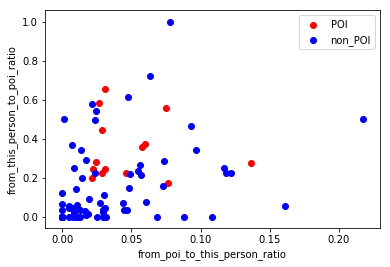

In [11]:
new_features = ["poi", 
                "from_poi_to_this_person_ratio",
                "from_this_person_to_poi_ratio",
                "shared_receipt_with_poi"]
new_data = featureFormat(data_dict, new_features)
new_labels, new_features = targetFeatureSplit(new_data) 
# Split our data into training and testing sets
new_features_train, new_features_test, new_labels_train, new_labels_test = train_test_split(
    new_features, new_labels, test_size=.25, random_state=3)
# Test our new data set is consistent
print len(new_labels)
print sum(new_labels)
# Plot our data
n_poi_x = []
n_poi_y = []
n_non_poi_x = []
n_non_poi_y = []
for i in range(len(new_labels)):
    x, y, _ = new_features[i]
    if new_labels[i] == 1:
        n_poi_x.append(x)
        n_poi_y.append(y)
    elif new_labels[i] == 0:
        n_non_poi_x.append(x)
        n_non_poi_y.append(y)
plt.scatter(n_poi_x, n_poi_y, color = "r", label = "POI")
plt.scatter(n_non_poi_x, n_non_poi_y, color = "b", label = "non_POI")
plt.legend()
plt.xlabel("from_poi_to_this_person_ratio")
plt.ylabel("from_this_person_to_poi_ratio")
plt.savefig("ratio_example_poi.png")
plt.show()

This ratio is definitely an improvement! Where as before, our POIs were scattered across the plot, in this plot we can that our red POI dots are clearly clustered in the center of our plot. In previous plots using total email counts, the fact that people in different positions have differing email requirements and so the plots are being distorted by absolute numbers, converting to ratios is definitely improving our signal. Therefore I think that we do not need to run outlier removal - this has the advantage of giving us a larger data set.

We now re-run our classifier to see if there is any performance improvement.

In [12]:
new_clf = KMeans(n_clusters=2, max_iter=100)
new_clf.fit(new_features_train)
new_pred = new_clf.predict(new_features_test)
clf_test(new_labels_test, new_pred)

Accuracy:  0.681818181818
Recall:  0.333333333333
Precision:  0.166666666667


We can see that performance is not improved from the regular data - however, we have one last wrinkle left - that is that fact that we have a ratio and also absolute numbers in the "shared_receipt_with_poi" field. We re-run without this field to only have ratios and see if there is any improvement in performance.

In [13]:
for i in range(len(new_labels)):
    x, y, _ = new_features[i]
    new_features[i] = [x, y]
# Split our data into training and testing sets
new_features_train, new_features_test, new_labels_train, new_labels_test = train_test_split(
    new_features, new_labels, test_size=.25, random_state=3)
new_clf = KMeans(n_clusters=2, max_iter=100)
new_clf.fit(new_features_train)
new_pred = new_clf.predict(new_features_test)
clf_test(new_labels_test, new_pred)
#print new_labels_test

Accuracy:  0.681818181818
Recall:  0.0
Precision:  0.0


We can see that our performance in identifying POIs is actually worse. Despite that, I think that from our plot we can see the advanatges of the ratios - however we will need to supplement them with other variables. In fact, such a classifier would be far too simple.

The next approach is to parse emails - one would think that POIs would leave traces of any "schemes" in their communications.

In [ ]:
# Parse emails???
